# Find optimal neural net to predict accurately

In [28]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set()

import sklearn
from sklearn import model_selection, decomposition

import tensorflow as tf
from tensorflow.keras import layers, models, metrics

pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

load data into a dataframe, remove match Id and human_players, and then describe it.

First 121 columns depict all hero.

In [29]:
# load data into a df
dota_df = pd.read_csv("../data/dota2_matches_old.csv")
dota_df = dota_df.drop(['match_id', 'human_players'], axis=1)

#column grouping
target_name = "dire_win"
human_players = "human_players"
hero_names = dota_df.columns[:121]
clusters = list(dota_df.columns[dota_df.columns.str.contains("cluster")])
stats = list(dota_df.columns[dota_df.columns.str.contains("max|min|avg|std")])

dota_df.describe()

Anti-Mage     Axe    Bane  Bloodseeker  Crystal Maiden  Drow Ranger  \
count     422.00  422.00  422.00       422.00          422.00       422.00   
mean        0.02    0.03    0.30         0.09            0.02         0.05   
std         0.17    0.20    0.62         0.35            0.17         0.27   
min         0.00    0.00    0.00         0.00            0.00         0.00   
25%         0.00    0.00    0.00         0.00            0.00         0.00   
50%         0.00    0.00    0.00         0.00            0.00         0.00   
75%         0.00    0.00    0.00         0.00            0.00         0.00   
max         2.00    2.00    2.00         2.00            2.00         2.00   

       Earthshaker  Juggernaut  Mirana  Morphling  Shadow Fiend  \
count       422.00      422.00  422.00     422.00        422.00   
mean          0.38        0.06    0.09       0.19          0.04   
std           0.69        0.29    0.38       0.53          0.25   
min           0.00        0.00    0.00       0.00          0.00   
25%           0.00        0.00    0.00       0.00          0.00   
50%           0.00        0.00    0.00       0.00          0.00   
75%           1.00        0.00    0.00       0.00          0.00   
max           2.00        2.00    2.00       2.00          2.00   

       Phantom Lancer    Puck   Pudge   Razor  Sand King  Storm Spirit  \
count          422.00  422.00  422.00  422.00     422.00        422.00   
mean             0.02    0.16    0.01    0.09       0.13          0.24   
std              0.18    0.50    0.15    0.35       0.44          0.59   
min              0.00    0.00    0.00    0.00       0.00          0.00   
25%              0.00    0.00    0.00    0.00       0.00          0.00   
50%              0.00    0.00    0.00    0.00       0.00          0.00   
75%              0.00    0.00    0.00    0.00       0.00          0.00   
max              2.00    2.00    2.00    2.00       2.00          2.00   

         Sven    Tiny  Vengeful Spirit  Windranger    Zeus  Kunkka    Lina  \
count  422.00  422.00           422.00      422.00  422.00  422.00  422.00   
mean     0.14    0.46             0.06        0.11    0.02    0.18    0.32   
std      0.47    0.79             0.30        0.43    0.21    0.52    0.64   
min      0.00    0.00             0.00        0.00    0.00    0.00    0.00   
25%      0.00    0.00             0.00        0.00    0.00    0.00    0.00   
50%      0.00    0.00             0.00        0.00    0.00    0.00    0.00   
75%      0.00    1.00             0.00        0.00    0.00    0.00    0.00   
max      2.00    2.00             2.00        2.00    2.00    2.00    2.00   

         Lion  Shadow Shaman  Slardar  Tidehunter  Witch Doctor    Lich  \
count  422.00         422.00   422.00      422.00        422.00  422.00   
mean     0.27           0.05     0.04        0.44          0.04    0.01   
std      0.59           0.28     0.26        0.71          0.24    0.13   
min      0.00           0.00     0.00        0.00          0.00    0.00   
25%      0.00           0.00     0.00        0.00          0.00    0.00   
50%      0.00           0.00     0.00        0.00          0.00    0.00   
75%      0.00           0.00     0.00        1.00          0.00    0.00   
max      2.00           2.00     2.00        2.00          2.00    2.00   

         Riki    Enigma  Tinker  Sniper  Necrophos  Warlock  Beastmaster  \
count  422.00  4.22e+02  422.00  422.00     422.00   422.00       422.00   
mean     0.01  7.11e-03    0.08    0.03       0.07     0.01         0.13   
std      0.15  1.09e-01    0.34    0.24       0.30     0.15         0.46   
min      0.00  0.00e+00    0.00    0.00       0.00     0.00         0.00   
25%      0.00  0.00e+00    0.00    0.00       0.00     0.00         0.00   
50%      0.00  0.00e+00    0.00    0.00       0.00     0.00         0.00   
75%      0.00  0.00e+00    0.00    0.00       0.00     0.00         0.00   
max      2.00  2.00e+00    2.00    2.00       

List each column with details, shows all columns as floating point values

In [30]:
print(dota_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Columns: 214 entries, Anti-Mage to cluster_mode_league27
dtypes: float64(214)
memory usage: 705.7 KB
None


Fix data issues:

<ul>
    <li>Convert hero variables from float to int of 1 and -1</li>
    <li>Convert cluster variables from float to int of 1 and 0</li>
</ul>

In [31]:
dota_df[hero_names] = dota_df[hero_names].replace(1.0, 'dire').replace(2.0, 'radiant').astype(str)
dota_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Columns: 214 entries, Anti-Mage to cluster_mode_league27
dtypes: float64(93), object(121)
memory usage: 705.7+ KB


In [32]:
dota_df[clusters] = dota_df[clusters].replace(1.0, 1).astype(int)
dota_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Columns: 214 entries, Anti-Mage to cluster_mode_league27
dtypes: float64(65), int32(28), object(121)
memory usage: 659.5+ KB


Split into train test and pass through neural network

In [33]:
features = dota_df.drop(target_name, axis=1)
target = dota_df[target_name].astype(bool)

Plot pairwise relationships in a dataset.

C:\Users\MUHAMM~1\AppData\Local\Temp/ipykernel_14076/3276791584.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features_norm = (features + features.mean())/features.std()


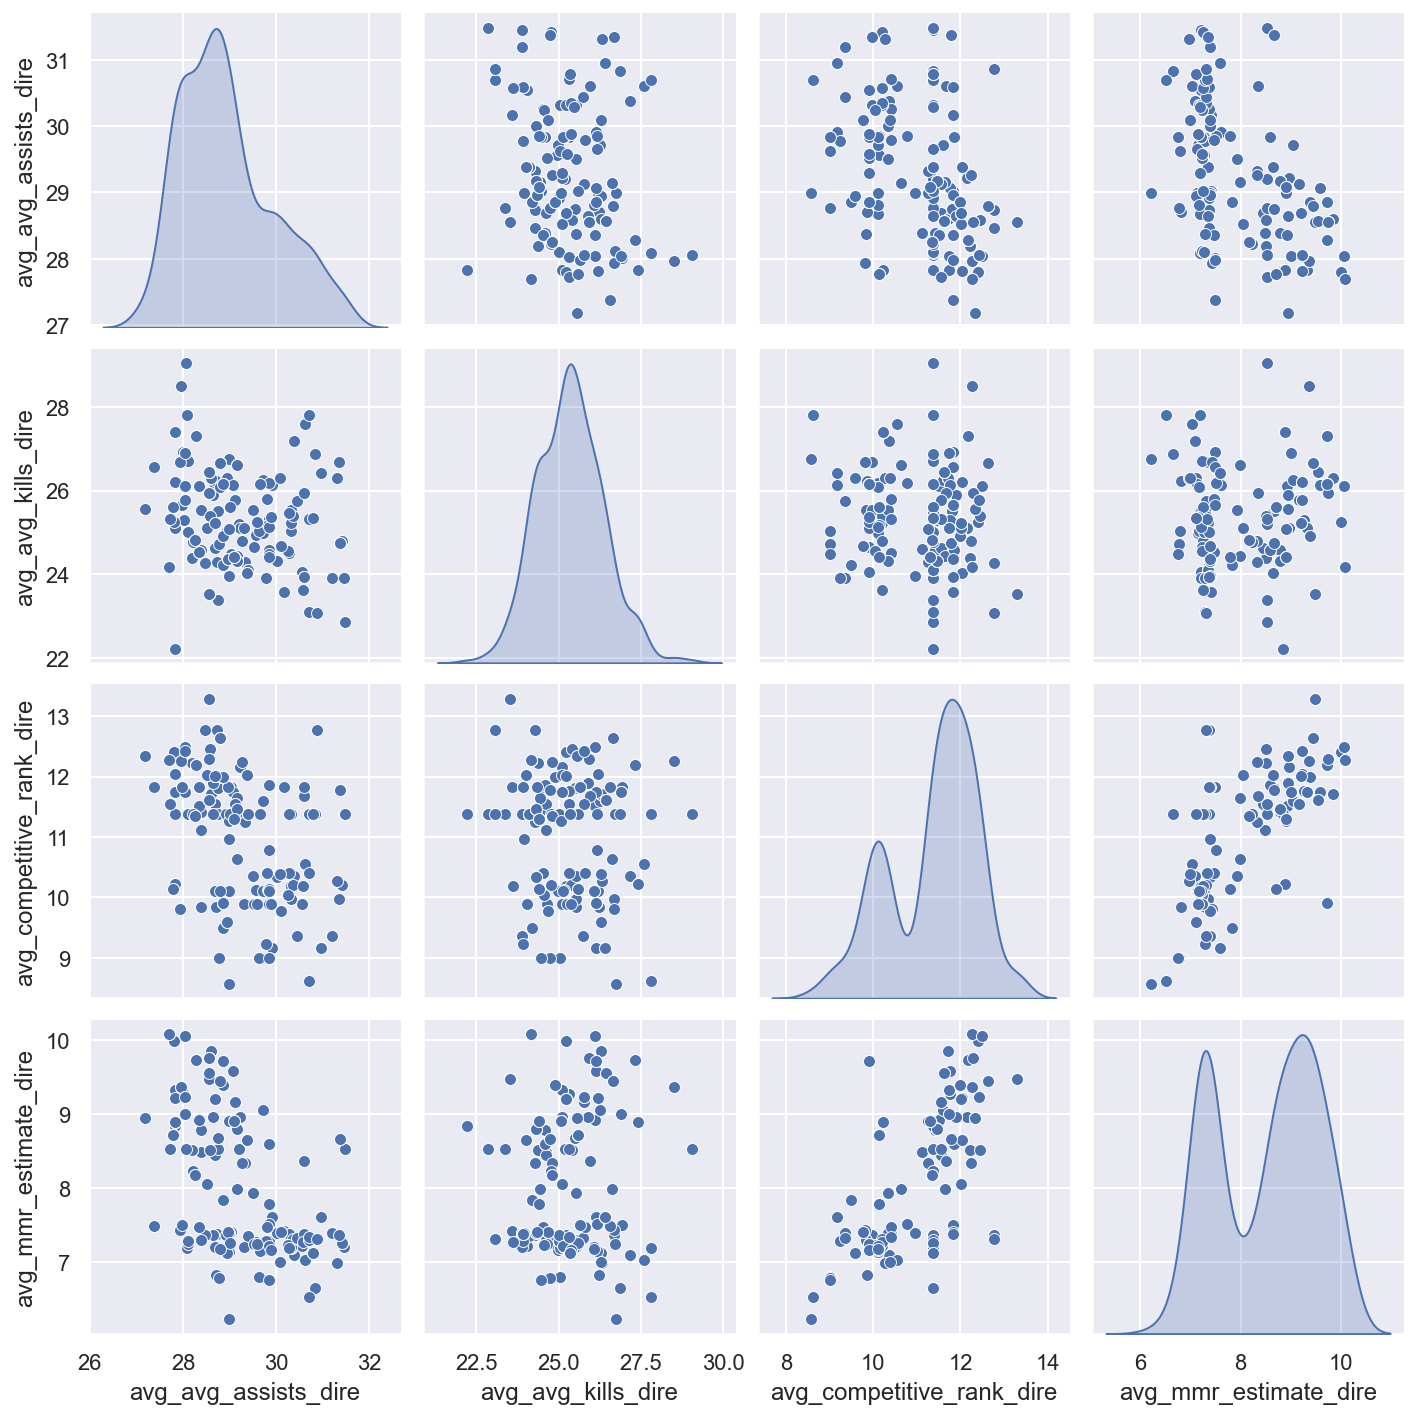

In [34]:
features_norm = (features + features.mean())/features.std()

sns.pairplot(features_norm[['avg_avg_assists_dire',
                       'avg_avg_kills_dire',
                       'avg_competitive_rank_dire',
                       'avg_mmr_estimate_dire']], diag_kind='kde')

Plot pairwise relationships in a dataset.

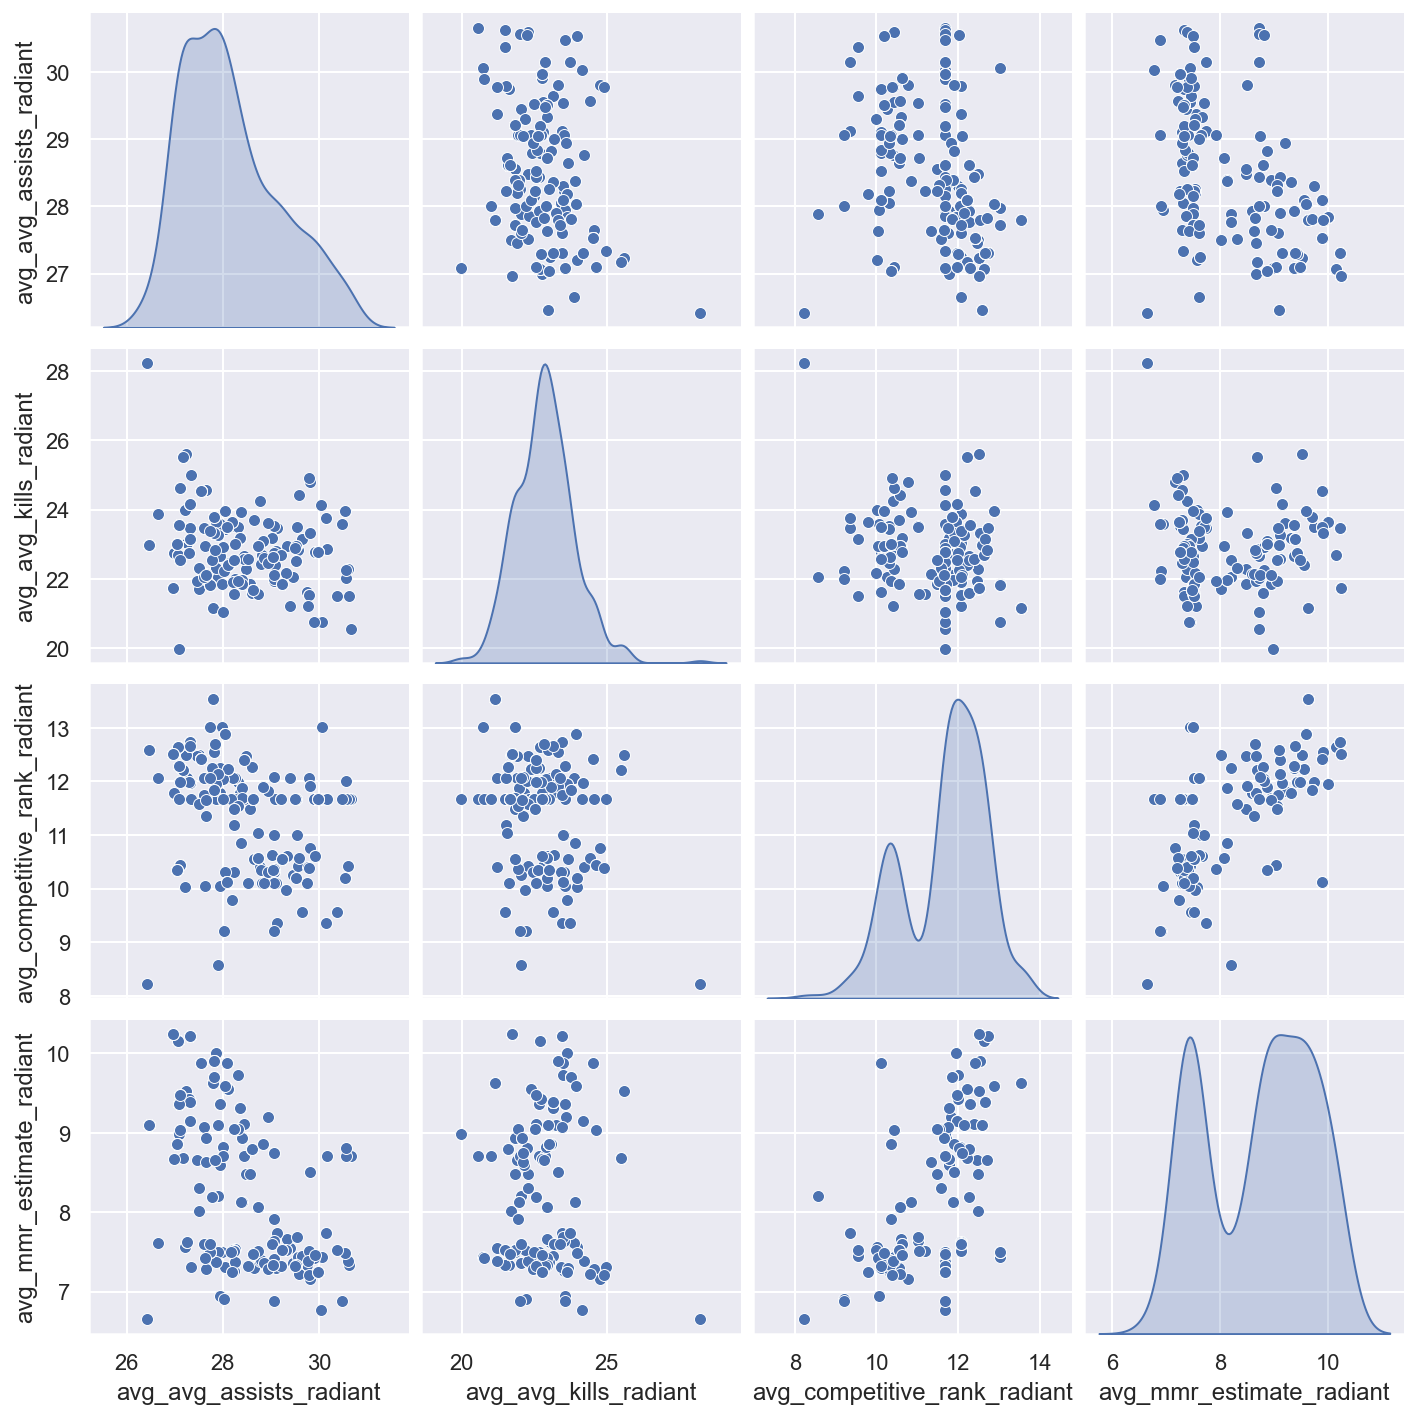

In [35]:
sns.pairplot(features_norm[['avg_avg_assists_radiant',
                       'avg_avg_kills_radiant',
                       'avg_competitive_rank_radiant',
                       'avg_mmr_estimate_radiant']], diag_kind='kde')


OHE on hero to convert categorical to binary

In [36]:
features = pd.get_dummies(features, columns=hero_names)

features.shape

(422, 451)

Split into train and test

In [37]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, shuffle=True,
                                                                    test_size=0.1, random_state=7)
X_train.shape

(379, 451)

Perform PCA on features with 2, 3, 7 PCA components

In [38]:
def perform_pca(train: pd.DataFrame, test: pd.DataFrame, components: int):
    pca = decomposition.PCA(n_components=components)
    pca = pca.fit(train)

    pca_train = pd.DataFrame(pca.transform(train))
    pca_train.index = train.index

    pca_test = pd.DataFrame(pca.transform(test))
    pca_test.index = test.index

    return pca_train, pca_test

X_train_pca_2, X_test_pca_2 = perform_pca(X_train, X_test, 2)
X_train_pca_3, X_test_pca_3 = perform_pca(X_train, X_test, 3)
X_train_pca_7, X_test_pca_7 = perform_pca(X_train, X_test, 7)


Plot PCA 2

Text(0, 0.5, 'PCA Component 2')

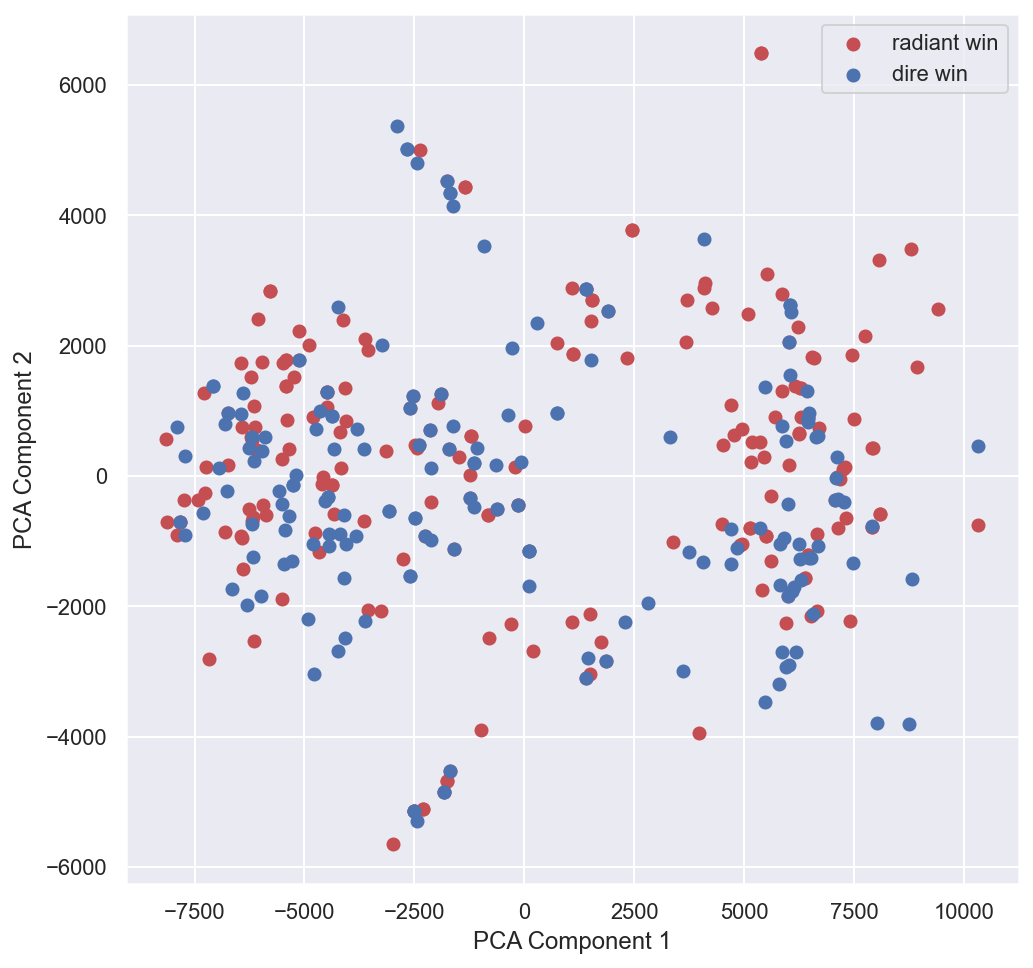

In [39]:
#plot the PCA with color labels
fig, ax = plt.subplots(figsize=(8, 8))
color = ['r', 'b']
label = ['radiant win', 'dire win']

for t in {0, 1}:
    win_mask = y_train == t
    ax.scatter(X_train_pca_2.values[win_mask, 0], X_train_pca_2.values[win_mask, 1],
             label=label[t], color=color[t])

ax.legend()
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

Plot PCA 3

C:\Users\MUHAMM~1\AppData\Local\Temp/ipykernel_14076/1459556709.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=48, azim=134)


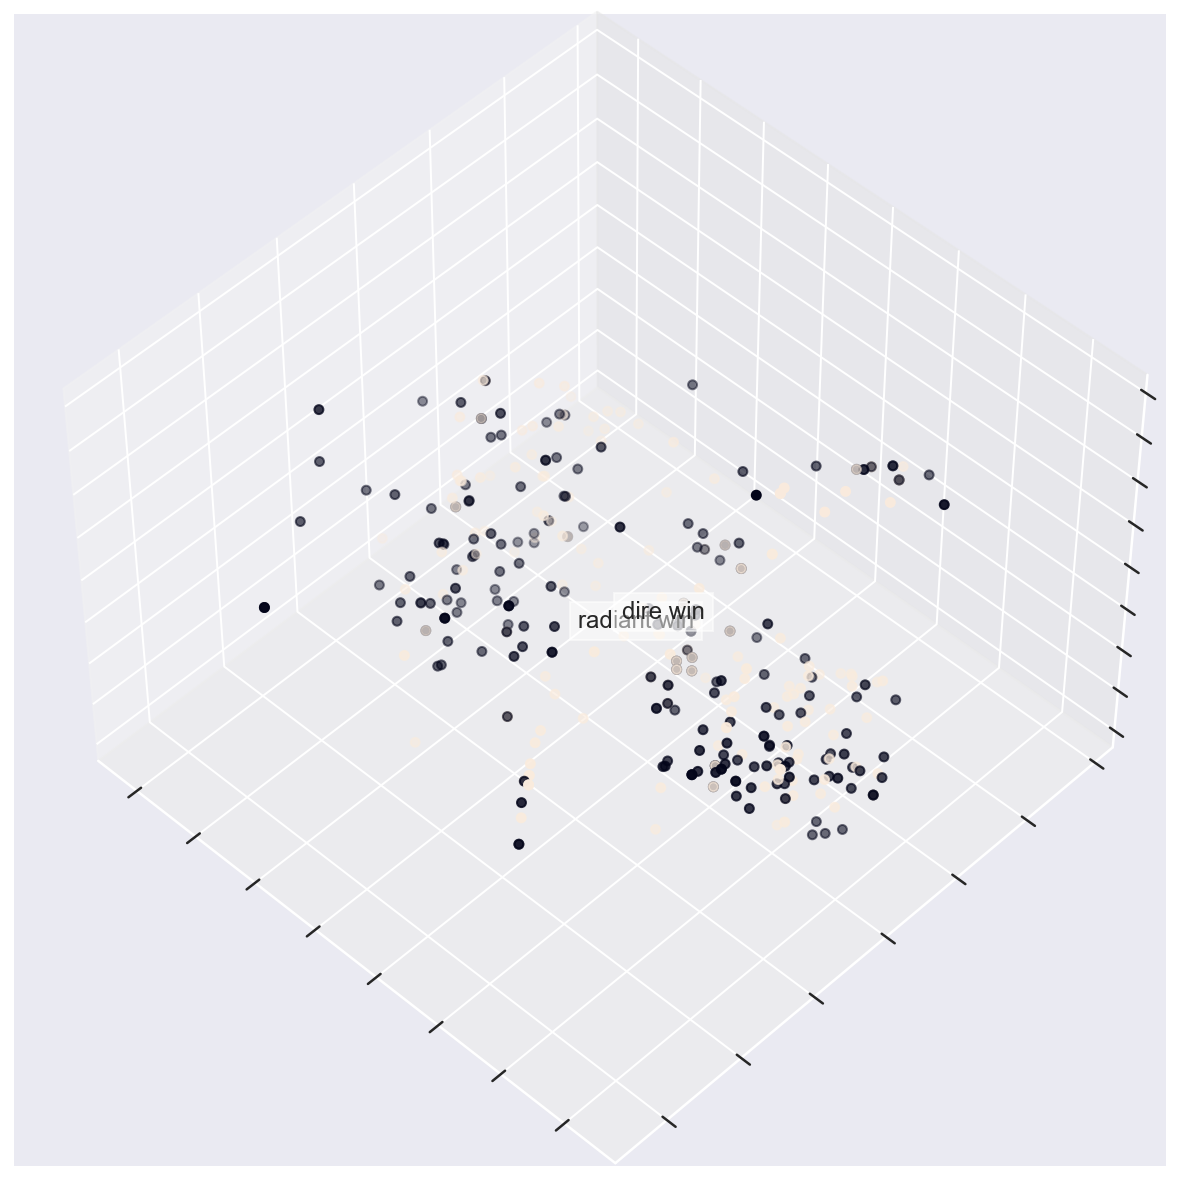

In [40]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, elev=48, azim=134)

for t in {0, 1}:
  ax.text3D(X_train_pca_3.values[y_train == t, 0].mean(),
            X_train_pca_3.values[y_train == t, 1].mean() + 1.5,
            X_train_pca_3.values[y_train == t, 2].mean(), label[t], horizontalalignment='center',
            bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

ax.scatter(X_train_pca_3.values[:, 0],
           X_train_pca_3.values[:, 1],
           X_train_pca_3.values[:, 2], c=y_train) #plotting the 3 clusters

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

Plot model loss

In [41]:
def plot_loss(data):
  plt.plot(data.history['loss'], label='loss')
  plt.plot(data.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

Function for training model

In [42]:
def train_model(seq_model, train, y):
    seq_model.compile(
      loss = tf.keras.losses.BinaryCrossentropy(),
      optimizer = tf.keras.optimizers.Adamax(5),
      metrics=[metrics.Accuracy()]
    )

    history = seq_model.fit(
        train,
        y,
        epochs=50,
        validation_split = 0.1
    )

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    print(seq_model.summary())
    return history

Create model and fit to it for all features

In [43]:
model = models.Sequential([
    tf.keras.layers.Normalization(axis=1), #normalize the input
    layers.Dense(451, activation='tanh'),
    layers.Dense(451, activation='relu'),
    layers.Dense(451, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='softmax'),
])

mod_history = train_model(model, X_train, y_train)

Epoch 1/50
11/11 [==============================] - 1s 48ms/step - loss: 23524783685632.0000 - accuracy: 0.4428 - val_loss: 0.7925 - val_accuracy: 0.5526
Epoch 2/50
11/11 [==============================] - 0s 9ms/step - loss: 0.7732 - accuracy: 0.4428 - val_loss: 0.8057 - val_accuracy: 0.5526
Epoch 3/50
11/11 [==============================] - 0s 9ms/step - loss: 0.7051 - accuracy: 0.4428 - val_loss: 0.7249 - val_accuracy: 0.5526
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.6922 - accuracy: 0.4428 - val_loss: 0.7002 

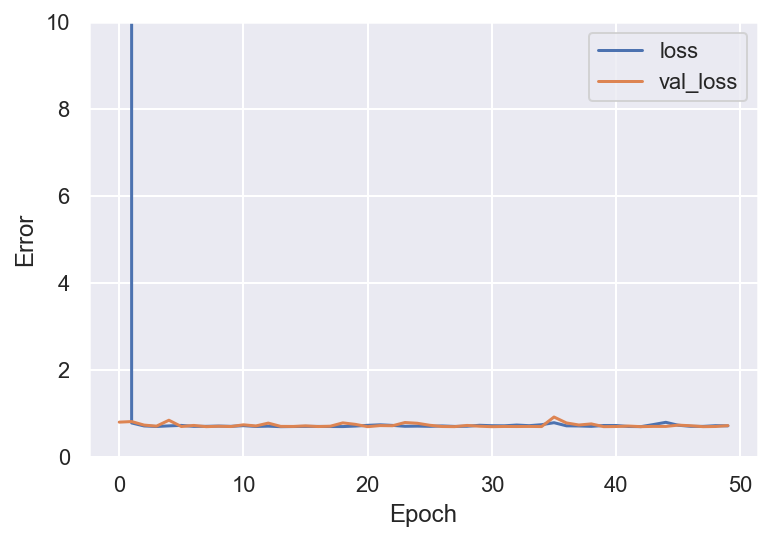

In [44]:
plot_loss(mod_history)

Get test set results

In [45]:
test_results = {'initial_model': model.evaluate(X_test, y_test, verbose=0)}

Create model and fit to it for 3 PCA features

In [46]:
pca_3_model = models.Sequential([
    tf.keras.layers.Normalization(axis=1), #normalize the input
    layers.Dense(3, activation='tanh'),
    layers.Dense(3, activation='relu'),
    layers.Dense(3, activation='relu'),
    layers.Dense(1, activation='softmax'),
])

pca_3_mod_history = train_model(pca_3_model, X_train_pca_3, y_train)

Epoch 1/50
11/11 [==============================] - 1s 20ms/step - loss: 1.1005 - accuracy: 0.4428 - val_loss: 0.8722 - val_accuracy: 0.5526
Epoch 2/50
11/11 [==============================] - 0s 10ms/step - loss: 0.8452 - accuracy: 0.4428 - val_loss: 0.7266 - val_accuracy: 0.5526
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.7478 - accuracy: 0.4428 - val_loss: 0.8140 - val_accuracy: 0.5526
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.7060 - accuracy: 0.4428 - val_loss: 0.7355 - val_accuracy: 0.5526
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.7308 - accuracy: 0.4428 - val_loss: 0.6987 - val_accuracy: 0.5526
Epoch 6/50
11/11 [====================

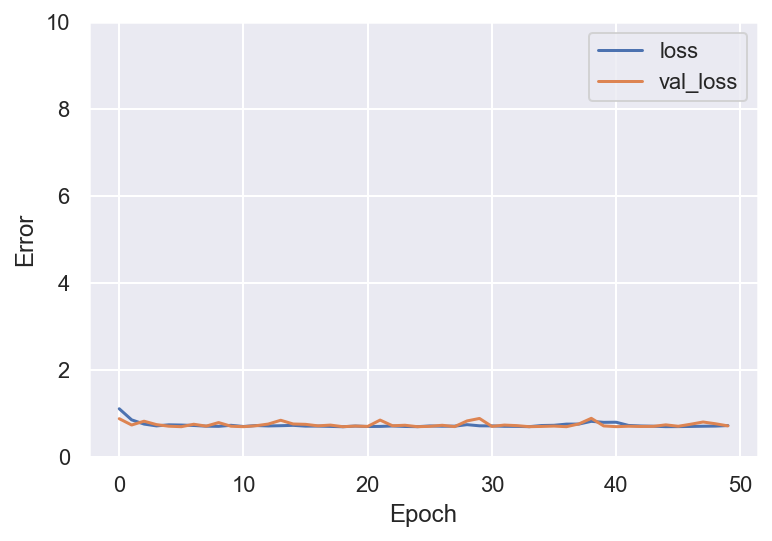

In [47]:
plot_loss(pca_3_mod_history)

Get test set results

In [48]:
test_results['pca_3_model'] = pca_3_model.evaluate(X_test_pca_3, y_test, verbose=0)

Create model and fit to it for 7 PCA features

In [49]:
pca_7_model = models.Sequential([
    tf.keras.layers.Normalization(axis=1), #normalize the input
    layers.Dense(7, activation='tanh'),
    layers.Dense(7, activation='relu'),
    layers.Dense(7, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='softmax'),
])

pca_7_mod_history = train_model(pca_7_model, X_train_pca_7, y_train)

Epoch 1/50
11/11 [==============================] - 1s 30ms/step - loss: 1.0661 - accuracy: 0.4428 - val_loss: 1.1450 - val_accuracy: 0.5526
Epoch 2/50
11/11 [==============================] - 0s 10ms/step - loss: 0.7155 - accuracy: 0.4428 - val_loss: 0.7547 - val_accuracy: 0.5526
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.7285 - accuracy: 0.4428 - val_loss: 0.6931 - val_accuracy: 0.5526
Epoch 4/50
11/11 [==============================] - 0s 13ms/step - loss: 0.7185 - accuracy: 0.4428 - val_loss: 0.7114 - val_accuracy: 0.5526
Epoch 5/50
11/11 [==============================] 

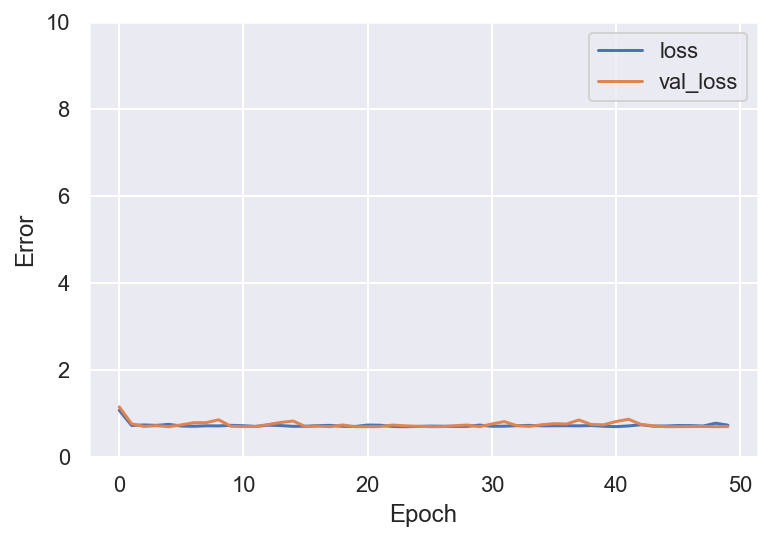

In [50]:
plot_loss(pca_7_mod_history)

Get test set results

In [51]:
test_results['pca_7_model'] = pca_7_model.evaluate(X_test_pca_7, y_test, verbose=0)

The test results on the models

In [52]:
test_results

{'initial_model': [0.6752299070358276, 0.39534884691238403],
 'pca_3_model': [0.6786243319511414, 0.39534884691238403],
 'pca_7_model': [0.6995267868041992, 0.39534884691238403]}